In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision.transforms import v2
from model import Autoencoder

import stan

import arviz as az

import nest_asyncio
nest_asyncio.apply()

### Define transforms and database

In [2]:
# prepare input transforms
trans = v2.Compose([
    v2.Resize((32, 32)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
# prepare imge conversion transforms
rev_trans = v2.Compose([
    v2.Lambda(lambda t: (t * 255).astype(np.uint8)),
    v2.ToPILImage(),
])
# declare fmnist dataset
fmnist = torchvision.datasets.FashionMNIST(root='./f_mnist', train=True, download=True, transform=trans)

### Define autoencoder

In [3]:
model = Autoencoder(img_size=32)
model.eval()
model.load_state_dict(torch.load('AE_10latents.pt'))

<All keys matched successfully>

### Pick latent vectors from $n$ samples

In [4]:
samples = [fmnist[i][0] for i in range(100)]
# samples

In [5]:
labels = [fmnist[i][1] for i in range(100)]
# labels

In [6]:
data_latents = [model.encoder(i.to('cuda')
                              .unsqueeze(axis=0))
                              .squeeze()
                              .detach()
                              .cpu() # up to here this is a torch tensor
                              .numpy()
                              .tolist() 
                for i in samples]

In [7]:
data = np.array(data_latents)
data.shape

(100, 10)

### Build and fit hierarchical model

In [8]:
program_code = """
data {
    int<lower=1> J; // number of images
    int<lower=1> F; // number of features
    int<lower=1> L;
    array[J] int<lower=1, upper=10> labels;
    array[J] vector[F] feature_vecs;
    vector<lower=0>[F] sigma;
}

parameters {
array[L] vector[F] theta;
//vector<lower=0>[F] sigma;
vector[F] mu;
vector<lower=0>[F] tau;
}

model {
    // hyper
    mu ~ normal(0, 5);
    tau ~ inv_gamma(1, 1);

    // priors
    theta ~ multi_normal(mu, diag_matrix(tau)); // conditional prior
    //sigma ~ cauchy(0, 5);

    // Likelihood
    for (j in 1:J) {
        feature_vecs[j] ~ multi_normal(theta[labels[j]], diag_matrix(sigma));
    }
}

generated quantities {
    array[L] vector[F] latents_stan;
    for (l in 1:L) {
        latents_stan[l] = multi_normal_rng(theta[l], diag_matrix(sigma));
    }
}
"""

Build stan model and generate latents

In [ ]:
# Prepare data in Stan friendly format
data_dict = {
    'J': data.shape[0],
    'F': data.shape[1],
    'labels': np.array(labels) + 1,
    'L': 10,
    'feature_vecs': data,
    'sigma': np.array([1. for _ in range(10)]),
}
# Compile model
partial_pooling_model1 = stan.build(program_code, data=data_dict)

# Fit model
partial_pooling_fit1 = partial_pooling_model1.sample(num_chains=4, num_warmup=1000, num_samples=1000)

### Visualize latent vectors sampled from hierarchical model

In [49]:
summary = az.summary(partial_pooling_fit1)

In [50]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"theta[0, 0]",-14.659,0.043,-14.743,-14.580,0.000,0.000,9177.0,2633.0,1.0
"theta[0, 1]",-0.075,0.042,-0.151,0.003,0.000,0.000,8628.0,2783.0,1.0
"theta[0, 2]",-12.670,0.042,-12.744,-12.590,0.000,0.000,8221.0,2647.0,1.0
"theta[0, 3]",-8.290,0.042,-8.370,-8.212,0.000,0.000,9124.0,2805.0,1.0
"theta[0, 4]",-13.639,0.042,-13.722,-13.563,0.000,0.000,8061.0,2824.0,1.0
...,...,...,...,...,...,...,...,...,...
"latents_stan[9, 5]",-4.692,1.014,-6.592,-2.859,0.016,0.011,4134.0,3796.0,1.0
"latents_stan[9, 6]",2.976,0.989,1.207,4.911,0.015,0.011,4100.0,4083.0,1.0
"latents_stan[9, 7]",-2.982,0.991,-4.763,-1.048,0.016,0.011,3826.0,3851.0,1.0
"latents_stan[9, 8]",55.987,1.004,54.134,57.888,0.016,0.011,3845.0,3513.0,1.0


In [53]:
# prepare sampled latent vectors
tmp = []
latents = summary['mean'].iloc[120:]
for i in range(10):
    l_vec = []
    for j in range(10):
       l_vec.append(latents[10*i + j])
    tmp.append(l_vec) 

Visualize generated latent vectors

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

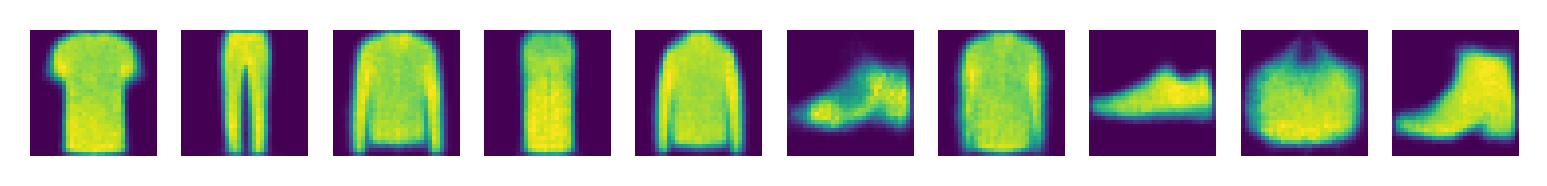

In [54]:
fig, ax = plt.subplots(1, 10, dpi=300)

for i in range(10):
    test = torch.FloatTensor(tmp[i]).to('cuda').unsqueeze(axis=0)
    reconstructed = model.decoder(test).squeeze().detach().cpu().numpy()
    img = rev_trans(reconstructed)
    
    ax[i].imshow(img)
    ax[i].axis('OFF')

plt.show()